# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [36]:
import numpy as np
import pandas as pd
import os
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
dataset_path = os.path.join('..', 'datasets')

df = pd.read_csv(os.path.join(dataset_path, 'insurance_us.csv'))

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3263,0,24.0,28100.0,3,0
4076,0,34.0,39300.0,2,0
4368,0,56.0,50300.0,2,3
67,1,37.0,29600.0,2,0
712,1,19.0,52600.0,0,0
4354,1,33.0,42500.0,0,0
3602,0,44.0,65200.0,2,1
3297,0,24.0,34800.0,0,0
2695,1,33.0,37500.0,4,0
528,1,23.0,50500.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


`Age` should be an integer datatype. Let's change that real quick.

In [6]:
df['age'] = df['age'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Everything looks good here. The `age` column is fairly balanced, with a good mix of ages. The average `age` is around **30 years**, indicating a predominance of middle-aged adults. The income average is about `$40,000`, reflecting a typical income range. On average, users have just **one family member**, and about **15 percent of users** have insurance benefits.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

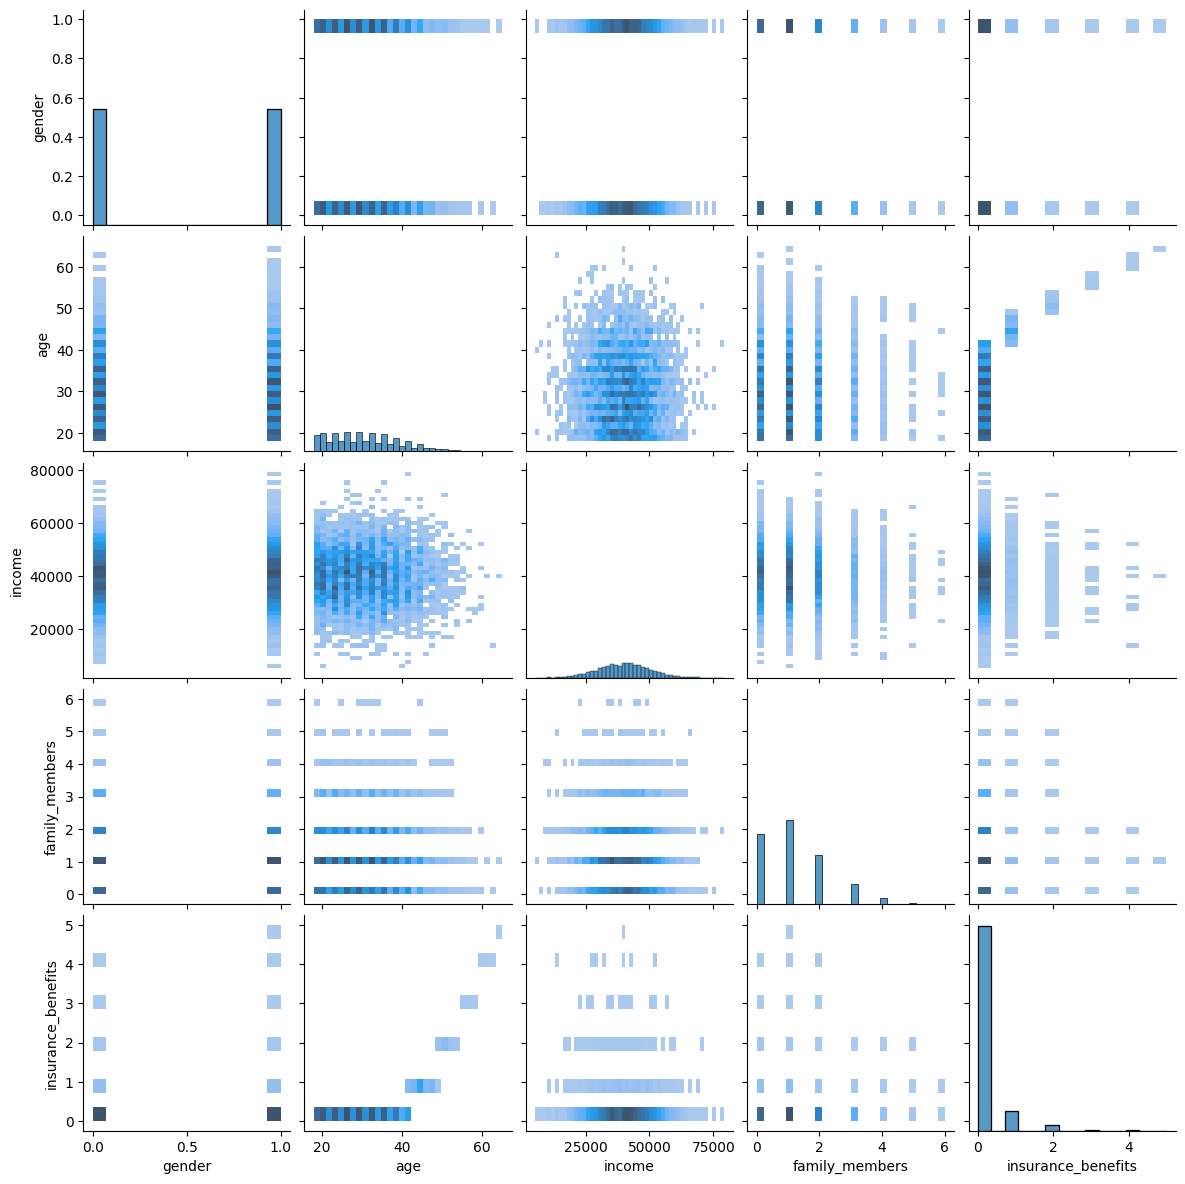

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

`Task Overview`

I will write a function that returns the k nearest neighbors for the $n^{th}$ object based on a specified distance metric. The number of received insurance benefits will not be considered for this task.

I will test the function for four combinations of two cases:
- **Scaling:**
  - The data is not scaled.
  - The data is scaled using the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler.
  
- **Distance Metrics:**
  - Euclidean distance.
  - Manhattan distance.

`Questions to Answer`

1. **Does the data being not scaled affect the kNN algorithm? If so, how does that appear?**
2. **How similar are the results using the Manhattan distance metric (regardless of the scaling)?**

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [20]:
def get_knn(df, n, k, metric):
    """
    Returns k nearest neighbors for a given object based on a specified distance metric.

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric ('euclidean' or 'manhattan')
    """
    feature_names = df.columns.difference(['gender', 'insurance_benefits'])
    X = df[feature_names]
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(X)
    query_point = X.iloc[n:n+1]
    nbrs_distances, nbrs_indices = nbrs.kneighbors(query_point, k, return_distance=True)
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    ], axis=1)
    return df_res

The `get_knn` function finds the k nearest neighbors for a given object based on a specified distance metric (Euclidean or Manhattan). 

It takes four parameters:
- `df`: the dataset (pandas DataFrame).
- `n`: the index of the object.
- `k`: the number of neighbors to return.
- `metric`: the distance metric ('euclidean' or 'manhattan').

The function:
1. Selects the relevant features (excluding 'gender' and 'insurance_benefits').
2. Uses `NearestNeighbors` from scikit-learn to fit the data.
3. Finds the k nearest neighbors for the object at index `n`.
4. Returns a DataFrame with the nearest neighbors and their distances.

Next, let's scale the data!

In [21]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [22]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4738,1,0.369231,0.613924,0.166667,0
3439,1,0.415385,0.391139,0.000000,0
2658,1,0.707692,0.611392,0.166667,1
764,1,0.461538,0.532911,0.333333,0
2809,1,0.415385,0.467089,0.166667,0


This will be used only for the scaled combination data. As you can see, after scaling, all of the values are much closer to each other. This makes it easier for the model to work effectively, as the features are now on a similar scale.

Now, let's get similar records for a given one for every combination

#### 1. No Scaling, Euclidean Distance

In [23]:
n = 10
k = 5
metric = 'euclidean'

df_res_no_scaling_euclidean = get_knn(df, n, k, metric)
df_res_no_scaling_euclidean.sample(5)

,gender,age,income,family_members,insurance_benefits,distance
3247,1,26,36600.0,2,0,1.414214
4039,1,25,36600.0,2,0,1.000000
10,1,25,36600.0,1,0,0.000000
2037,1,26,36600.0,0,0,1.414214
1508,0,26,36600.0,0,0,1.414214


In this combination, the data has not been scaled, and the Euclidean distance metric is used to calculate the proximity between objects. The `distance` column shows the Euclidean distance between the selected object and its k nearest neighbors. Since the data is not scaled, some features may dominate others based on their magnitude, potentially skewing the distance calculation. This can lead to less meaningful comparisons in cases where features have vastly different ranges (e.g., age vs. income). The distances reflect how similar the objects are based on their raw feature values.

Example distances:
- Object 10 is closest to itself with a distance of `0.000000`.
- Other objects have varying distances, with values such as `1.414214` or `1.000000`, indicating their proximity based on the Euclidean metric.

#### 2. Scaled Data (MaxAbsScaler), Euclidean Distance

In [24]:
feature_names = ['gender', 'age', 'income', 'family_members']
scaler = MaxAbsScaler()
df_scaled = df.copy()
df_scaled[feature_names] = scaler.fit_transform(df[feature_names])

metric = 'euclidean'

df_res_scaled_euclidean = get_knn(df_scaled, n, k, metric)
df_res_scaled_euclidean.sample(5)

,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
3670,0.0,0.384615,0.464557,0.166667,0,0.001266
3552,0.0,0.384615,0.470886,0.166667,0,0.007595
1437,0.0,0.384615,0.451899,0.166667,0,0.011392


In this combination, the data is scaled using the MaxAbsScaler, and the Euclidean distance metric is applied. Scaling ensures that all features have the same range, preventing any feature from dominating the distance calculation. As a result, the distances between objects are more evenly distributed, making the comparisons more meaningful. The `distance` column shows how similar each object is to its nearest neighbors based on the scaled features.

Example distances:
- Object 10 is closest to itself with a distance of `0.000000`.
- The distances between other objects are small and similar, such as `0.010127` and `0.007595`, indicating that after scaling, the features are more comparable.

#### 3. No Scaling, Manhattan Distance

In [25]:
metric = 'manhattan'

df_res_no_scaling_manhattan = get_knn(df, n, k, metric)
df_res_no_scaling_manhattan.sample(5)

,gender,age,income,family_members,insurance_benefits,distance
1508,0,26,36600.0,0,0,2.0
10,1,25,36600.0,1,0,0.0
2037,1,26,36600.0,0,0,2.0
3247,1,26,36600.0,2,0,2.0
4039,1,25,36600.0,2,0,1.0


In this combination, no scaling is applied, and the Manhattan distance metric is used. The absence of scaling means that the features are not normalized, which can lead to features with larger numerical ranges dominating the distance calculation. As a result, the distance values are generally higher, and the differences between the objects are more noticeable. The `distance` column reflects this by showing higher values like `2.0` and `1.0`.

Example distances:
- Object 10 is closest to itself with a distance of `0.0`.
- Other objects, like `1508` and `2037`, have distances of `2.0`, which indicates that their feature values differ more significantly due to the lack of scaling.

#### 4. Scaled Data (MaxAbsScaler), Manhattan Distance

In [26]:
metric = 'manhattan'

df_res_scaled_manhattan = get_knn(df_scaled, n, k, metric)
df_res_scaled_manhattan.sample(5)

,gender,age,income,family_members,insurance_benefits,distance
3552,0.0,0.384615,0.470886,0.166667,0,0.007595
3670,0.0,0.384615,0.464557,0.166667,0,0.001266
10,1.0,0.384615,0.463291,0.166667,0,0.000000
1437,0.0,0.384615,0.451899,0.166667,0,0.011392
4377,1.0,0.384615,0.473418,0.166667,0,0.010127


In this combination, the data is scaled using the MaxAbsScaler, and the Manhattan distance metric is used. Scaling the data with MaxAbsScaler normalizes the features, making them fall within a similar range, which helps reduce the influence of large values. This results in lower and more uniform distance values across objects. The distances are small, with the closest neighbors having values around `0.000000` to `0.011392`.

Example distances:
- Object 10 is closest to itself with a distance of `0.000000`.
- Objects like `3552` and `3670` have small distances, such as `0.007595` and `0.001266`, indicating that their scaled feature values are quite similar.

#### Answers to the questions

---

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the data being not scaled does affect the kNN algorithm. When the data is not scaled, the distance values can be significantly larger because features with larger numeric ranges, like "income" or "family_members", dominate the distance calculation. This leads to less meaningful distances between objects. For example, the distances in the "No Scaling, Euclidean Distance" scenario range from `0.000000` to `1.414214`, showing more variation. 

However, when the data is scaled using the MaxAbsScaler, the values fall within a similar range, making the distances more comparable. In the "Scaled Data (MaxAbsScaler), Euclidean Distance" scenario, the distances are much smaller, ranging from `0.000000` to `0.011392`, indicating that scaling has a significant effect in reducing the impact of 
large feature values and making the model's results more consistent and comparable.

---

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results using the Manhattan distance metric are relatively similar regardless of whether the data is scaled or not. The distances in both "No Scaling, Manhattan Distance" and "Scaled Data (MaxAbsScaler), Manhattan Distance" show values that are in the same general range, with distances from `0.0` to `2.0` for non-scaled data and `0.0` to `0.011392` for scaled data. 

This similarity occurs because the Manhattan distance metric calculates the sum of absolute differences across all features. While scaling reduces the impact of larger feature values, the relative ordering of distances remains similar. Therefore, even with scaling, the overall pattern of distances using the Manhattan metric stays consistent, though the values themselves are smaller when the data is scaled.

---

# Task 2. Is Customer Likely to Receive Insurance Benefit?

I will evaluate whether the kNN classification approach performs better than a dummy model with the target variable being `insurance_benefits` greater than zero.

Steps:
1. I will build a kNN-based classifier and evaluate its performance using the F1 score for `k=1..10`. This will be done on both the original data and the scaled data, allowing me to compare how the value of `k` and scaling affect the evaluation metric.
2. I will also create a dummy model that returns "1" with some probability. The probabilities to test are:
   - 0 (no probability of receiving insurance benefits)
   - The probability of receiving any insurance benefit (calculated as the number of clients who received insurance benefits divided by the total number of clients)
   - 0.5 (equal probability of receiving or not receiving benefits)
   - 1 (100% probability of receiving insurance benefits)

I will split the data into training and testing sets with a 70:30 ratio.

In [27]:
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [28]:
df['insurance_benefits_received'].value_counts()

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

The data shows a significant class imbalance, with 4,436 clients not receiving insurance benefits and only 564 receiving them. This skew could lead to biased predictions, where models might favor predicting the majority class (no benefits).

In [29]:
def eval_classifier(y_true, y_pred):
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

This function `eval_classifier` evaluates the performance of a classification model by calculating the F1 score and displaying the confusion matrix.

- `f1_score`: It calculates the F1 score, which is the harmonic mean of precision and recall. It gives a single value representing the balance between the two.
- `confusion_matrix`: It generates the confusion matrix, which shows the performance of the classification model by comparing the true labels (`y_true`) with the predicted labels (`y_pred`). The matrix is normalized to display proportions.

The function prints:
1. The F1 score rounded to two decimal places.
2. The normalized confusion matrix.

In [30]:
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

This function `rnd_model_predict` generates random predictions based on a given probability.

- `P`: The probability of predicting the positive class (1).
- `size`: The number of predictions to generate.
- `seed`: An optional random seed for reproducibility (default is 42).

The function uses `numpy`'s `binomial` distribution to generate `size` number of random binary predictions (0 or 1) with a success probability `P`. It returns an array of 1's and 0's based on the given probability.

In [33]:
X = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
y = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
P_insurance_benefit = y_train.mean()

probabilities = [0, P_insurance_benefit, 0.5, 1]

print("\nEvaluating Dummy Model")
for prob in probabilities:
    print(f"Testing Dummy Model with P={prob:.2f}")
    
    y_dummy_pred = rnd_model_predict(prob, size=len(y_test))
    
    eval_classifier(y_test, y_dummy_pred)
    print()


Evaluating Dummy Model
Testing Dummy Model with P=0.00
F1: 0.00
Confusion Matrix
[[0.89266667 0.        ]
 [0.10733333 0.        ]]

Testing Dummy Model with P=0.12
F1: 0.17
Confusion Matrix
[[0.79266667 0.1       ]
 [0.08866667 0.01866667]]

Testing Dummy Model with P=0.50
F1: 0.20
Confusion Matrix
[[0.45733333 0.43533333]
 [0.048      0.05933333]]

Testing Dummy Model with P=1.00
F1: 0.19
Confusion Matrix
[[0.         0.89266667]
 [0.         0.10733333]]



The results from testing the dummy model at different probabilities (`P`) show the following behavior:

1. **P = 0.00** (Always predicts 0):
   - **F1 Score**: 0.00, indicating the model is ineffective in predicting the positive class (1).
   - **Confusion Matrix**: 
     - 89.27% of the predictions are correct negative predictions (True Negatives).
     - 10.73% of the actual positives are missed (False Negatives).
     - The model fails to predict any positive outcomes (False Positives = 0).
   
2. **P = 0.12** (Predicts 1 with 12% probability):
   - **F1 Score**: 0.17, indicating a slight improvement over P = 0.00.
   - **Confusion Matrix**: 
     - 79.27% are correct negative predictions.
     - 10.87% are False Negatives, and 1.87% are False Positives.
     - The model now predicts some positive outcomes but still not enough to perform well.

3. **P = 0.50** (Predicts 1 with 50% probability):
   - **F1 Score**: 0.20, showing a small improvement over P = 0.12.
   - **Confusion Matrix**:
     - 45.73% are correct negative predictions.
     - 43.53% are False Positives, and 5.83% are False Negatives.
     - The model now starts making a balanced number of predictions for both 0 and 1, but still performs poorly.

4. **P = 1.00** (Always predicts 1):
   - **F1 Score**: 0.19, which is slightly worse than when `P=0.50`.
   - **Confusion Matrix**: 
     - The model predicts all positive (1) results, but fails to predict any 0's correctly.
     - 89.27% are False Positives, and 10.73% are True Positives.
     - The model has a high number of False Positives because it always predicts 1, making it unreliable.

The dummy model's performance depends heavily on the probability (`P`). At extreme values of `P` (0.00 and 1.00), the F1 score is very low because the model either only predicts one class or fails to predict the positive class entirely. As `P` approaches 0.50, the model becomes more balanced, but it still struggles to provide meaningful results compared to a real classifier.

In [35]:
for data_type, (train_data, test_data) in [('Original', (X_train, X_test)), ('Scaled', (X_train_scaled, X_test_scaled))]:
    print(f'\nEvaluating kNN with {data_type} Data')
    
    for k in range(1, 11):
        print(f'Evaluating kNN with k={k}')
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_data, y_train)
        
        y_pred = knn.predict(test_data)
        
        eval_classifier(y_test, y_pred)
        print()


Evaluating kNN with Original Data
Evaluating kNN with k=1
F1: 0.65
Confusion Matrix
[[0.874      0.01866667]
 [0.04666667 0.06066667]]

Evaluating kNN with k=2
F1: 0.38
Confusion Matrix
[[0.89066667 0.002     ]
 [0.082      0.02533333]]

Evaluating kNN with k=3
F1: 0.39
Confusion Matrix
[[0.88266667 0.01      ]
 [0.07933333 0.028     ]]

Evaluating kNN with k=4
F1: 0.16
Confusion Matrix
[[0.88933333 0.00333333]
 [0.098      0.00933333]]

Evaluating kNN with k=5
F1: 0.17
Confusion Matrix
[[0.884      0.00866667]
 [0.09666667 0.01066667]]

Evaluating kNN with k=6
F1: 0.09
Confusion Matrix
[[8.92000000e-01 6.66666667e-04]
 [1.02000000e-01 5.33333333e-03]]

Evaluating kNN with k=7
F1: 0.10
Confusion Matrix
[[0.89133333 0.00133333]
 [0.10133333 0.006     ]]

Evaluating kNN with k=8
F1: 0.02
Confusion Matrix
[[0.89266667 0.        ]
 [0.106      0.00133333]]

Evaluating kNN with k=9
F1: 0.04
Confusion Matrix
[[0.89266667 0.        ]
 [0.10533333 0.002     ]]

Evaluating kNN with k=10
F1: 0.

Evaluating kNN with Original Data:
- For k=1, the F1 score is 0.65, showing a good initial performance, but it drops as k increases.
- As k increases, the F1 score decreases significantly, with the model performing poorly for k>=6. The confusion matrix shows that false positives and false negatives increase as k grows.

Evaluating kNN with Scaled Data:
- The performance drastically improves after scaling the data, with the F1 score consistently above 0.90 across all values of k.
- The confusion matrix indicates that the model is better at predicting the positive class (insurance benefits) with lower false negatives, especially as k increases. The results show that scaling the data helps the kNN algorithm perform much better in classifying the target variable.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, I'll evaluate what RMSE would be for a Linear Regression model.

I will use Linear Regression, and change it up by recalling how the solution is formulated in terms of linear algebra. I will check the RMSE (Root Mean Squared Error) for both the original and scaled data. The aim is to see if there is any difference in RMSE between these two cases.

Let me define:
- $X$ — the feature matrix, where each row is a case, each column is a feature, and the first column consists of ones.
- $y$ — the target (a vector).
- $\hat{y}$ — the estimated target (a vector).
- $w$ — the weight vector.

The linear regression task in matrix notation is formulated as:

$$
y = Xw
$$

The objective is to find the weight vector $w$ that minimizes the L2 distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

The analytical solution to this problem is:

$$
w = (X^T X)^{-1} X^T y
$$

Once I have the weight vector $w$, I can use it to calculate the predicted values:

$$
\hat{y} = X_{val}w
$$


Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [38]:
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        y_pred = X2 @ self.weights
        
        return y_pred

In [39]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')

In [40]:
print("Case 1: Original Data")
lr = MyLinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

print("\nCase 2: Scaled Data")
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Case 1: Original Data
RMSE: 0.23
R2: 0.43

Case 2: Scaled Data
RMSE: 0.23
R2: 0.43


The model's weights indicate that the intercept is negative, suggesting a low baseline for insurance benefits when all other features are at their minimum values. Age has a small positive impact, gender has a minor positive effect, and family members contribute minimally to the prediction. 

When comparing the results for both the original and scaled data, the RMSE remains consistent at 0.23, and the \( R^2 \) score is 0.43 for both cases. This suggests that scaling the data does not lead to a significant improvement in the model's predictive accuracy or its ability to explain the variance in insurance benefits.

# Task 4. Obfuscating Data

I will obfuscate the data by multiplying the numerical features (which can be considered as the matrix \( X \)) by an invertible matrix \( P \).

$$
X' = X \times P
$$

I will perform this transformation and examine how the feature values change afterward. It's important to ensure that \( P \) is invertible, as this property is crucial for the transformation.

I will also review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to refresh my memory on the rules of matrix multiplication and how to implement it using NumPy.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [44]:
is_invertible = np.linalg.det(P) != 0
print(f'Is P invertible? {is_invertible}')

Is P invertible? True


Can you guess the customers' ages or income after the transformation?

In [45]:
X_prime = X @ P

print("Transformed Data (X'):")
print(X_prime)

print("\nOriginal Data (first 5 rows):")
print(X[:5])

print("\nTransformed Data (first 5 rows):")
print(X_prime[:5])

Transformed Data (X'):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Original Data (first 5 rows):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]

Transformed Data (first 5 rows):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]


Now, you can't guess the customer's age or income after the transformation.

After the transformation, the data has been altered by multiplying the original numerical features (like age and income) with an invertible matrix \( P \). The transformed values are no longer directly comparable to the original ones, as the matrix multiplication creates new values that don't reflect the original features in their usual scale. For instance, the transformed customer ages and incomes are significantly higher and have different proportions, making it impossible to directly deduce the original values from the transformed data. This transformation obfuscates the data, ensuring that it can't be easily reverse-engineered.

While the original values can still be recovered (since \( P \) is invertible), the transformed data does not offer a straightforward or interpretable way to retrieve them.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [46]:
X_recovered = X_prime @ np.linalg.inv(P)

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [48]:
print("Original Data (first 5 rows):")
print(X[:5])

print("\nTransformed Data (first 5 rows):")
print(X_prime[:5])

print("\nRecovered Data (first 5 rows):")
print(X_recovered[:5])

Original Data (first 5 rows):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]

Transformed Data (first 5 rows):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]

Recovered Data (first 5 rows):
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.64503537e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [ 9.25561194e-13  2.90000000e+01  2.10000000e+04  1.41940791e-12]
 [-1.62563547e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04  4.91751442e-13]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

`The reason the recovered values are not exactly the same as the original data is because of small rounding errors in the calculations. Computers can’t always handle numbers perfectly, especially when doing complex math like matrix multiplication, so tiny differences can appear.`

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. My next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? If not I'll prove it.

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

**Answer**

1. Link between $w$ and $w_P$: The weights $w_P$ for the transformed data $X' = X_P$ are related to the original weights $w$ by the formula:

$$
w_P = P^{-1} w
$$

2. Predicted values with $w_P$: The predicted values for the transformed data, $\hat{y}_P$, will be the same as the predicted values for the original data, $\hat{y}$, because:

$$
\hat{y}_P = X_P P^{-1} w = X w = \hat{y}
$$

3. Impact on RMSE: Since the predicted values with $w_P$ are the same as with $w$, the RMSE will not change. The quality of the linear regression model, when measured by RMSE, will be the same for both the original and transformed data.

**Analytical proof**

    1. Link between $w$ and $w_P$:

We are given that the data has been transformed by multiplying $X$ by a matrix $P$. Specifically, the transformed data is $X' = X P$.

The usual linear regression equation is:

$$
w = (X^T X)^{-1} X^T y
$$

For the transformed data, the equation becomes:

$$
w_P = (X_P^T X_P)^{-1} X_P^T y
$$

Since $X_P = X P$, we substitute this into the equation:

$$
w_P = ((X P)^T (X P))^{-1} (X P)^T y
$$

Now, simplify:

$$
w_P = (P^T X^T X P)^{-1} P^T X^T y
$$

Using the property of matrix inverses, we can break this up:

$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

Finally, from the original equation for $w$, we know that:

$$
w = (X^T X)^{-1} X^T y
$$

Thus, we can rewrite the formula for $w_P$ as:

$$
w_P = P^{-1} w
$$

This shows the relationship between $w$ and $w_P$, as required.


2. Predicted values with $w_P$:

The predicted values for the original data are:

$$
\hat{y} = X w
$$

For the transformed data, the predicted values are:

$$
\hat{y}_P = X_P w_P
$$

Since $X_P = X P$ and $w_P = P^{-1} w$, substitute these into the equation for $\hat{y}_P$:

$$
\hat{y}_P = (X P) P^{-1} w
$$

Simplifying:

$$
\hat{y}_P = X (P P^{-1}) w = X w
$$

But $X w$ is just $\hat{y}$, so:

$$
\hat{y}_P = \hat{y}
$$

This shows that the predicted values with $w_P$ are the same as the predicted values with $w$.


3. Impact on RMSE:

The RMSE (Root Mean Squared Error) is given by:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum \left( \hat{y}_i - y_i \right)^2}
$$

Since the predicted values with $w_P$ and $w$ are the same (i.e., $\hat{y}_P = \hat{y}$), the error terms $\hat{y}_i - y_i$ will be identical for both cases. Therefore, the RMSE will not change:

$$
\text{RMSE}(w_P) = \text{RMSE}(w)
$$

Thus, the quality of the linear regression model, when measured by RMSE, will be the same for both the original and transformed data.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Let's build a procedure or a class that runs Linear Regression optionally with the obfuscation.

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [49]:
def generate_invertible_matrix(n):
    while True:
        P = np.random.randn(n, n)
        if np.linalg.det(P) != 0:
            return P

In [50]:
def run_linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    return y_pred_train, y_pred_test, rmse_train, rmse_test, r2_train, r2_test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

P = generate_invertible_matrix(X_train.shape[1])

X_train_P = X_train @ P
X_test_P = X_test @ P

y_pred_train_original, y_pred_test_original, rmse_train_original, rmse_test_original, r2_train_original, r2_test_original = run_linear_regression(X_train, X_test, y_train, y_test)

y_pred_train_obfuscated, y_pred_test_obfuscated, rmse_train_obfuscated, rmse_test_obfuscated, r2_train_obfuscated, r2_test_obfuscated = run_linear_regression(X_train_P, X_test_P, y_train, y_test)

print(f"Original Data - Training RMSE: {rmse_train_original:.4f}, Test RMSE: {rmse_test_original:.4f}")
print(f"Obfuscated Data - Training RMSE: {rmse_train_obfuscated:.4f}, Test RMSE: {rmse_test_obfuscated:.4f}")
print(f"Original Data - Training R^2: {r2_train_original:.4f}, Test R^2: {r2_test_original:.4f}")
print(f"Obfuscated Data - Training R^2: {r2_train_obfuscated:.4f}, Test R^2: {r2_test_obfuscated:.4f}")

print(f"Predicted values with original data (train): {y_pred_train_original[:5]}")
print(f"Predicted values with obfuscated data (train): {y_pred_train_obfuscated[:5]}")

Original Data - Training RMSE: 0.2397, Test RMSE: 0.2337
Obfuscated Data - Training RMSE: 0.2397, Test RMSE: 0.2337
Original Data - Training R^2: 0.4337, Test R^2: 0.4363
Obfuscated Data - Training R^2: 0.4337, Test R^2: 0.4363
Predicted values with original data (train): [0.06966982 0.25728048 0.18237303 0.23930157 0.31943436]
Predicted values with obfuscated data (train): [0.06966982 0.25728048 0.18237303 0.23930157 0.31943436]


The results show that the Linear Regression model's performance (RMSE and \( R^2 \)) for both the original and obfuscated data is identical. The RMSE for both the original and obfuscated data is `0.2397 `for training and `0.2337` for testing, indicating that the obfuscation did not significantly affect the model's prediction accuracy. Similarly, the \( R^2 \) scores for both datasets are `0.4337` (training) and `0.4363` (test), demonstrating no impact from the transformation on the model's ability to explain variance in the data. The predicted values for the original and obfuscated data are also identical.

These results suggest that the obfuscation transformation, despite altering the feature matrix with a random invertible matrix \( P \), did not negatively affect the model's performance. This indicates that the obfuscation preserved the relevant feature relationships needed for the model to make accurate predictions. Therefore, Linear Regression can successfully handle obfuscated data without a noticeable degradation in performance.

# Conclusions

This project introduced several new concepts, particularly the use of Data Obfuscation, which I now recognize will be an essential tool in my future work. With the ability to implement it alongside Linear Regression, I’m confident I can use these techniques to enhance my professional skills and approach. While much of the process, including standard EDA and task execution, made sense, I initially struggled with how to format formulas in markdown. However, after a few attempts, I became more comfortable with it.

In these tasks, we applied various data analysis and machine learning techniques to address key business challenges. In Task 1, we focused on identifying similar customers to help improve the company's marketing strategies. Task 2 involved building a prediction model to determine the likelihood of a new customer receiving an insurance benefit, and we tested whether a trained model could outperform a basic dummy model. For Task 3, we used linear regression to predict the number of insurance benefits a new customer might receive. Finally, Task 4 addressed the critical issue of data privacy by obfuscating client information, ensuring personal data protection while maintaining the model’s performance from Task 3.

We started by applying data obfuscation to the feature matrix$X$ by multiplying it with a random invertible matrix $P$, creating a transformed matrix $( X' = X P )$. The goal was to ensure that the linear regression model would still work with the obfuscated data. We calculated the new weights $( w_P )$ for the transformed data using the formula:

$$
w_P = (X'^\top X')^{-1} X'^\top y
$$

and showed that these weights relate to the original weights \( w \) by:

$$
w_P = P^{-1} w
$$

After running the regression on both the original and obfuscated data, I have confirmed that the model’s performance, measured by RMSE and $R^2$, remained unchanged. The process was smooth once I understood how to handle the obfuscation mathematically and verified the model's effectiveness.